In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


4423680/4422102 [==============================] - 2s 1us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


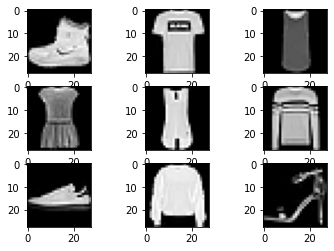

In [2]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
from scipy.ndimage import gaussian_filter
io=[]


# Gaussian =gaussian_filter(X_train[i], sigma=4)
# z1=X_train[i]-Gaussian
# io.append(z1)
# io=np.array(io)
# print(io.shape)

for i in range(60000):
  Gaussian =gaussian_filter(X_train[i], sigma=4)
  z=X_train[i]-Gaussian
  io.append(z)
io=np.array(io)
print(io.shape)
op=[]
for j in range(10000):
  Gaussian =gaussian_filter(X_test[j], sigma=4)
  z1=X_test[j]-Gaussian
  op.append(z1)
op=np.array(op)
print(op.shape)

(60000, 28, 28)
(10000, 28, 28)


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


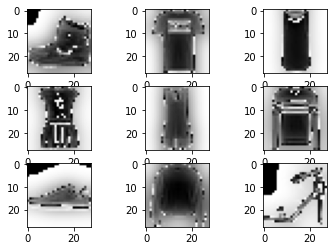

In [4]:
#Summary after Gaussian filter
print('Train: X=%s, y=%s' % (io.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (op.shape, Y_test.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(io[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [0]:
#Defining constants
epochs = 200
batch_size = 100
data_augmentation = False
img_size = 28

num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [6]:
x_train = io.reshape(io.shape[0],img_size,img_size,1)
x_test = op.reshape(op.shape[0],img_size,img_size,1)
input_size = (img_size, img_size,1)
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('Y_train shape:', Y_train.shape)

#Converting labels to one-hot vectors
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Y_train shape: (60000,)


In [7]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 14, 14, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [8]:
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet20_Original_Image-model_gaussian_filter_4.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]


/content/saved_model/fmnist_resnet20_Original_Image-model_gaussian_filter_4.h5


In [9]:
if not data_augmentation:
    print('Using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Using data augmentation.
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 50s 827us/step - loss: 1.3162 - accuracy: 0.8136 - val_loss: 1.0412 - val_accuracy: 0.8452

Epoch 00001: val_loss improved from inf to 1.04123, saving model to /content/saved_model/fmnist_resnet20_Original_Image-model_gaussian_filter_4.h5
Epoch 2/200
60000/60000 [==============================] - 38s 633us/step - loss: 0.8677 - accuracy: 0.8692 - val_loss: 0.8609 - val_accuracy: 0.8301

Epoch 00002: val_loss improved from 1.04123 to 0.86085, saving model to /content/saved_model/fmnist_resnet20_Original_Image-model_gaussian_filter_4.h5
Epoch 3/200
60000/60000 [==============================] - 38s 632us/step - loss: 0.6837 - accuracy: 0.8871 - val_loss: 0.7916 - val_accuracy: 0.8377

Epoch 00003: val_loss improved from 0.86085 to 0.79162, saving model to /content/saved_model/fmnist_resnet20_Original_Image-model_gaussian_filter_4.h5
Epoch 4/200
60000/60000

In [14]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



10000/10000 [==============================] - 3s 295us/step
Test loss: 1.4270100945949555
Test accuracy: 0.8848000168800354


In [0]:
model.save("fmnist_resnet20_Original_Image-model_gaussian_filter_4.h5")

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

1 conv2d_1 (7, 7, 1, 64)


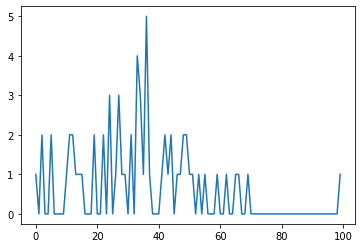

2 conv2d_2 (3, 3, 64, 64)


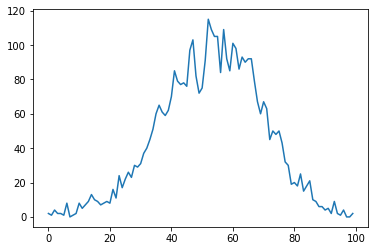

3 conv2d_3 (3, 3, 64, 64)


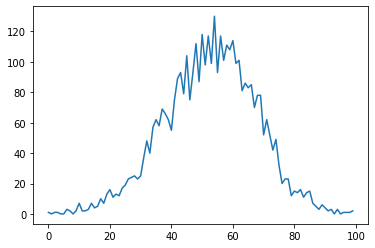

4 conv2d_4 (3, 3, 64, 64)


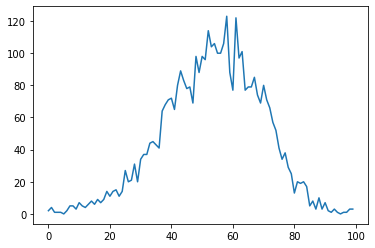

5 conv2d_5 (3, 3, 64, 64)


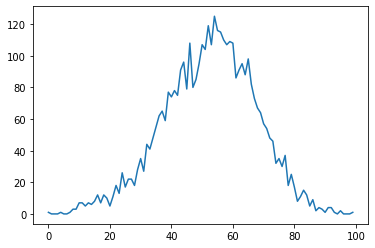

6 conv2d_6 (3, 3, 64, 128)


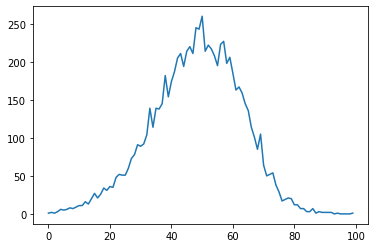

7 conv2d_7 (3, 3, 128, 128)


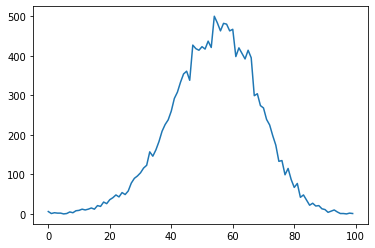

8 conv2d_9 (3, 3, 128, 128)


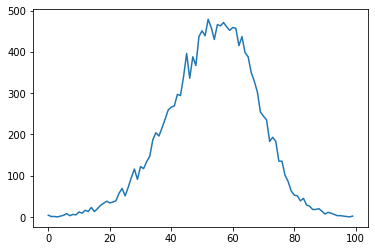

9 conv2d_10 (3, 3, 128, 128)


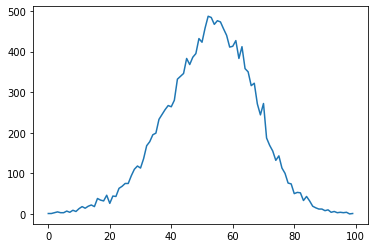

10 conv2d_11 (3, 3, 128, 256)


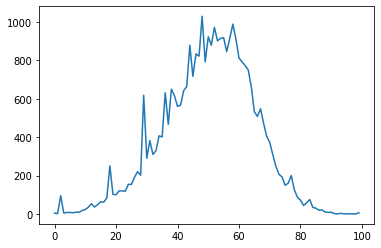

11 conv2d_12 (3, 3, 256, 256)


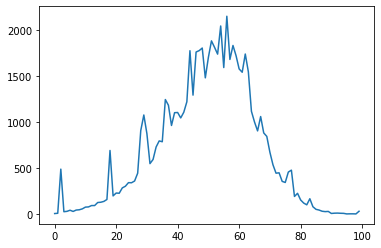

12 conv2d_14 (3, 3, 256, 256)


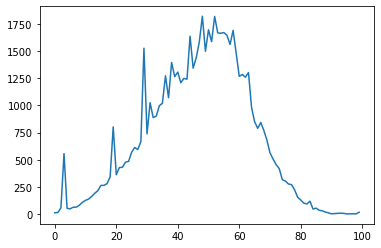

13 conv2d_15 (3, 3, 256, 256)


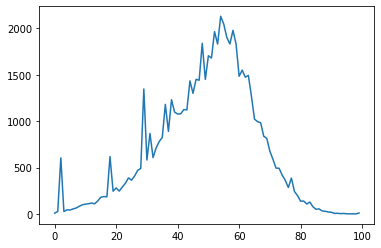

14 conv2d_16 (3, 3, 256, 512)


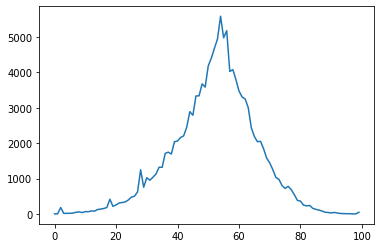

15 conv2d_17 (3, 3, 512, 512)


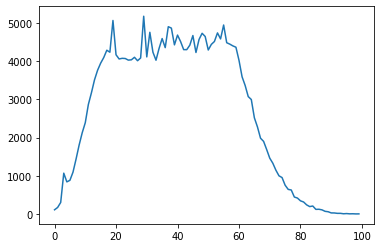

16 conv2d_19 (3, 3, 512, 512)


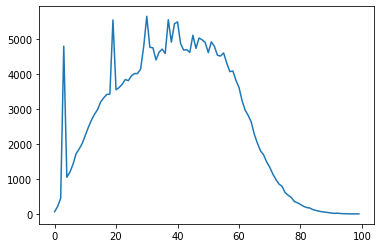

17 conv2d_20 (3, 3, 512, 512)


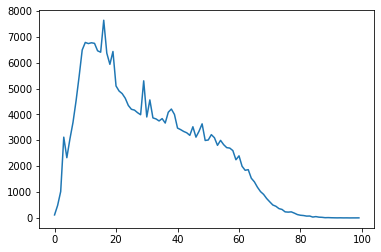

In [19]:
# Iterate over layers
plot_filt=0
n_pad=15
layer_counter=0
for layer in model.layers:
	  # check for convolutional layer
    if 'conv' in layer.name:
        # if filters are 3x3 or larger:
        if layer.kernel.shape[0]>=3 and layer.kernel.shape[1]>=3:
            layer_counter+=1
            list_f_response=np.zeros(layer.kernel.shape[-2]*layer.kernel.shape[-1])
            # summarize kernel shape
            print(layer_counter,layer.name,layer.kernel.shape)
            filter_counter=0
            # Iterate over every 3x3 filter in this layer
            for in_ch in range(layer.kernel.shape[-2]):
                for out_ch in range(layer.kernel.shape[-1]):
                    # pad and fft the filters
                    p_filter=layer.kernel[:,:,in_ch,out_ch]
                    filter_pad=np.pad(p_filter,pad_width=n_pad,mode='constant',constant_values=0)
                    filter_fft=np.fft.fftshift(np.abs(np.fft.fft2(filter_pad))**2)
                    filter_fft=filter_fft/np.sum(filter_fft)
                    # plot some fft examples
                    if filter_counter<plot_filt:
                        plt.imshow(filter_fft)
                        plt.colorbar()
                        plt.pause(1)
                    
                    # get x and y axis to quantify HP/LP structure
                    f_axis_0=np.arange(filter_fft.shape[0])
                    f_axis_0[f_axis_0>np.floor(filter_fft.shape[0]/2)]=np.flip(np.arange(np.floor(filter_fft.shape[0]/2))+1)
                    f_axis_0=np.fft.fftshift(f_axis_0)
                    f_axis_1=np.arange(filter_fft.shape[1])
                    f_axis_1[f_axis_1>np.floor(filter_fft.shape[1]/2)]=np.flip(np.arange(np.floor(filter_fft.shape[1]/2))+1)
                    f_axis_1=np.fft.fftshift(f_axis_1)

                    Y,X=np.meshgrid(f_axis_0,f_axis_1)
                    euc_dist=np.sqrt(X**2+Y**2)
                    mean_f_response=np.mean(euc_dist*filter_fft)
                    list_f_response[filter_counter]=mean_f_response

                    filter_counter+=1
            hist,bins=np.histogram(list_f_response,bins=100)
            plt.plot(hist)
            plt.savefig("fig_g4"+layer.name+".png")
            plt.pause(1)